# ARIMA training
This is an auto-generated notebook. To reproduce these results, attach this notebook to the **henry data's Cluster** cluster and rerun it.
- Compare trials in the [MLflow experiment](#mlflow/experiments/2402465695741674/s?orderByKey=metrics.%60val_mse%60&orderByAsc=true)
- Navigate to the parent notebook [here](#notebook/2402465695741675) (If you launched the AutoML experiment using the Experiments UI, this link isn't very useful.)
- Clone this notebook into your project folder by selecting **File > Clone** in the notebook toolbar.

Runtime Version: _11.1.x-cpu-ml-scala2.12_

In [0]:
import mlflow
import databricks.automl_runtime

target_col = "siniestros"
time_col = "date"
unit = "day"

horizon = 360

## Load Data

In [0]:
from mlflow.tracking import MlflowClient
import os
import uuid
import shutil
import pandas as pd
import pyspark.pandas as ps

# Create temp directory to download input data from MLflow
input_temp_dir = os.path.join("/dbfs/tmp/", str(uuid.uuid4())[:8])
os.makedirs(input_temp_dir)

# Download the artifact and read it into a pandas DataFrame
input_client = MlflowClient()
input_data_path = input_client.download_artifacts("b303c3756fb1448e9137f7356680db23", "data", input_temp_dir)

input_file_path = os.path.join(input_data_path, "training_data")
input_file_path = "file://" + input_file_path
df_loaded = ps.from_pandas(pd.read_parquet(input_file_path))

# Preview data
df_loaded.head(5)

,date,siniestros
0,2021-07-08,305
1,2021-07-20,286
2,2020-07-13,290
3,2021-08-27,349
4,2020-05-13,212


## Train ARIMA model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/2402465695741674/s?orderByKey=metrics.%60val_mse%60&orderByAsc=true)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment

In [0]:
# Define the search space of seasonal period m
seasonal_periods = [1, 7]

### Aggregate data by `time_col`
Group the data by `time_col`, and take average if there are multiple `target_col` values in the same group.

In [0]:
group_cols = [time_col]
df_aggregated = df_loaded \
  .groupby(group_cols) \
  .agg(y=(target_col, "avg")) \
  .reset_index() \
  .rename(columns={ time_col : "ds" })

df_aggregated.head()

,ds,y
0,2021-07-08,305.0
1,2021-07-20,286.0
2,2020-07-13,290.0
3,2021-08-27,349.0
4,2020-05-13,212.0


In [0]:
result_columns = ["pickled_model", "mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]

def arima_training(history_pd):
  from databricks.automl_runtime.forecast.pmdarima.training import ArimaEstimator

  arima_estim = ArimaEstimator(horizon=horizon, frequency_unit=unit, metric="mse",
                              seasonal_periods=seasonal_periods, num_folds=20)

  results_pd = arima_estim.fit(history_pd)
 
  return results_pd[result_columns]

In [0]:
import mlflow
from databricks.automl_runtime.forecast.pmdarima.model import ArimaModel, mlflow_arima_log_model

with mlflow.start_run(experiment_id="2402465695741674", run_name="ARIMA") as mlflow_run:
  mlflow.set_tag("estimator_name", "ARIMA")

  arima_results = arima_training(df_aggregated.to_pandas())
    
  # Log metrics to mlflow
  metric_names = ["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]
  avg_metrics = arima_results[metric_names].mean().to_frame(name="mean_metrics").reset_index()
  avg_metrics["index"] = "val_" + avg_metrics["index"].astype(str)
  avg_metrics.set_index("index", inplace=True)
  mlflow.log_metrics(avg_metrics.to_dict()["mean_metrics"])

  # Save the model to mlflow
  pickled_model = arima_results["pickled_model"].to_list()[0]
  arima_model = ArimaModel(pickled_model, horizon, unit, df_aggregated["ds"].min(), df_aggregated["ds"].max(), time_col)

  # Generate sample input dataframe
  sample_input = df_loaded.tail(5).to_pandas()
  sample_input[time_col] = pd.to_datetime(sample_input[time_col])
  sample_input.drop(columns=[target_col], inplace=True)

  mlflow_arima_log_model(arima_model, sample_input=sample_input)

In [0]:
avg_metrics

,mean_metrics
index,
val_mse,2446.947965
val_rmse,47.996582
val_mae,40.918779
val_mape,0.134310
val_mdape,0.130013
val_smape,0.146789
val_coverage,0.993864


## Analyze the predicted results

In [0]:
# Load the model
run_id = mlflow_run.info.run_id
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

2022/09/08 21:34:44 WARNING mlflow.pyfunc: Encountered an unexpected error (AttributeError("module 'pickle' has no attribute '__version__'")) while detecting model dependency mismatches. Set logging level to DEBUG to see the full traceback.


In [0]:
# Predict future with the default horizon
forecast_pd = loaded_model._model_impl.python_model.predict_timeseries()

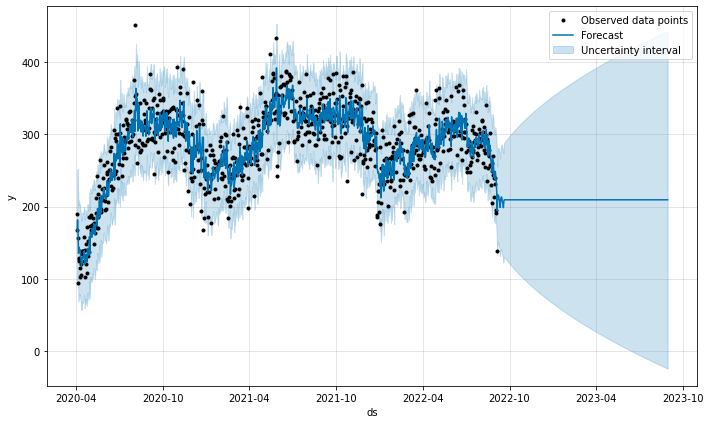

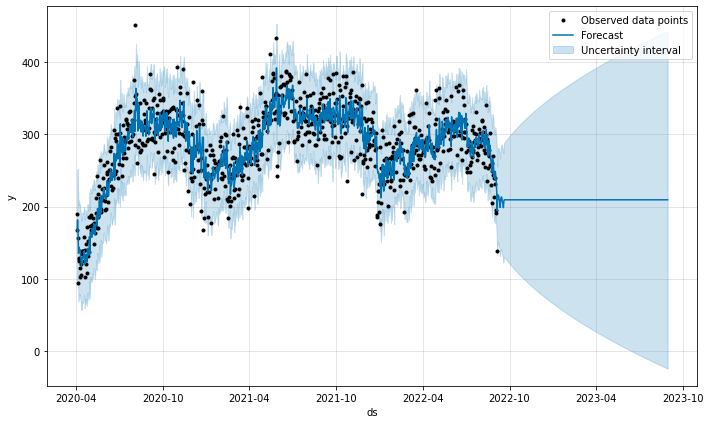

In [0]:
from databricks.automl_runtime.forecast.pmdarima.utils import plot

history_pd = df_aggregated.to_pandas()
# When visualizing, we ignore the first d (differencing order) points of the prediction results
# because it is impossible for ARIMA to predict the first d values
d = loaded_model._model_impl.python_model.model().order[1]
fig = plot(history_pd[d:], forecast_pd[d:])
fig

## Show the predicted results

In [0]:
predict_cols = ["ds", "yhat"]
forecast_pd = forecast_pd.reset_index()
display(forecast_pd[predict_cols].tail(horizon))

ds,yhat
2022-09-05T00:00:00.000+0000,194.49286458978287
2022-09-06T00:00:00.000+0000,216.68194941896508
2022-09-07T00:00:00.000+0000,212.65864370616663
2022-09-08T00:00:00.000+0000,215.03338365323052
2022-09-09T00:00:00.000+0000,209.38559014169934
2022-09-10T00:00:00.000+0000,209.07082234955215
2022-09-11T00:00:00.000+0000,198.9819038650426
2022-09-12T00:00:00.000+0000,206.97531465584595
2022-09-13T00:00:00.000+0000,211.99415204379855
2022-09-14T00:00:00.000+0000,213.47531554197755
